In [1]:
from transformers import AutoConfig, AutoModel, AutoTokenizer
import torch
import os

da = torch.device("cuda:0")
db = torch.device("cuda:1")
dc = torch.device("cuda:2")
tokenizer = AutoTokenizer.from_pretrained("/data/yanghq/models/THUDM/chatglm2-6b", trust_remote_code=True)

/data/yanghq/utils/anaconda3/envs/glm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
config = AutoConfig.from_pretrained("/data/yanghq/models/THUDM/chatglm2-6b", trust_remote_code=True, pre_seq_len=128)
model = AutoModel.from_pretrained("/data/yanghq/models/THUDM/chatglm2-6b", config=config, trust_remote_code=True)
checkpoint_path = "/data/yanghq/nlp_ptuning/output/128-5e-2-1000/checkpoint-1000"

prefix_state_dict = torch.load(os.path.join(checkpoint_path, "pytorch_model.bin"))
new_prefix_state_dict = {}
for k, v in prefix_state_dict.items():
    if k.startswith("transformer.prefix_encoder."):
        new_prefix_state_dict[k[len("transformer.prefix_encoder."):]] = v
model.transformer.prefix_encoder.load_state_dict(new_prefix_state_dict)
model = model.quantize(4)
model = model.to(da)
model = model.eval()
ma=0
mb=0
mc=0

Loading checkpoint shards: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /data/yanghq/models/THUDM/chatglm2-6b and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
p = '在本任务中，您将获得一段文本，您的任务是生成该文本的摘要。'
l=['6月12日，在该机构报名安全员c证，该机构承诺疫情期间与住建部门合作，可拿到住建部安全员c证，据了解住建部不与任何部门合作，该公司存在虚假宣传，欺骗消费者',
   '举报该店铺其涉嫌商标侵权与反不正当竞争行为，商标权所有人:陕西三正医药有限公司并未授权该店铺隶属企业使用“三正”商标。诉求:该店铺立即停止侵权行为，书面致歉，其他违法行为由执法机关依据法律法规处理，请下架店铺链接',
   '我于3月6日，通过武汉百城致胜汽车销售有限公司（办公地址：蔡甸区常福新城龙王社区A栋10-11-12号五星龙膜汽车生活会馆，注册地址：洪山区珞狮南路517号明泽大厦13楼1356号，洪山区市场称该公司不在注册地经营），在汉阳区王家湾沃尔沃4S店签订了购车（沃尔沃xc60）协议，价格为37万，办理10万贷款，并当场支付给武汉百城致胜汽车销售有限公司法人周旗10万订车款。3月7日，周旗本人电话通知我说4S店可以开票，要求我支付剩下17万车款，至此一共支付给周旗27w，但该公司却没有给票，提车时间一直推，等了三周后询问4s店称只收到周旗打的5000元定金，剩下26.5万的尾款一直没有收到。3月30日经过沟通后我于4月4日找到该公司法人周旗，通过协商，该公司退还了10万元并签订新的协议，承诺4月16日交付车（沃尔沃xc60），或退还剩余17万?3万违约金，现在该公司既不退款也不交车，并持续拖延',
   '本人于2019年底在湖北省黄石市阳新县好莱客门店定制了全屋的衣柜、酒柜等，入住后随着衣柜挂的衣服慢慢增多，发现衣柜门不能正常关闭，经多方面了解，原来是衣柜深度不够，后来查阅相关装修网站，发现正常标准衣柜深度最低的在530公分，普遍在550至600公分，而我家的衣柜深度只有512公分（含背板和柜门），后来我咨询身边装修的朋友，说可以通过将挂衣杆向后移的方法能解决柜门不能正常关的问题，于是我就找当地好莱客门店沟通，要求店面让师傅上门解决，后来师傅也上门了，也把晾衣杆向后移了，发现由于柜体深度实在太浅，向后移晾衣杆也没办法有效解决柜门不能正常关的问题，之后再跟门店沟通时，门店就以各种理由逃避责任，后来我向好莱客总部（广州好莱客创新家居有限公司）客服先后打了4通投诉电话，也在好莱客总部网站反映了我的问题和诉求，可是经过3天后，我主动联系好莱客总部客服，得到的回复是解决不了，希望通过贵平台能解决。',
   ]
for i in range(len(l)):
    l[i]=p+l[i]


In [13]:
# ll=[[],[],[],[]]
for i in range(4):
    for _ in range(3):
        r, _ = model.chat(tokenizer, l[i], history=[])
        ll[i].append(r)
    

In [14]:
ll

[['住建部安全员c证不靠谱',
  '住建部安全员c证被曝假证住建部不与其合作',
  '住建部安全员c证不与任何部门合作',
  '住建部安全员c证不认可，公司承诺疫情期间与住建部门合作',
  '住建部安全员c证“假证”住建部不与任何部门合作',
  '住建部安全员c证被质疑存在虚假宣传欺骗消费者',
  '住建部安全员c证报名公司被指虚假宣传',
  '安全员c证“承诺”住建部发证',
  '住建部安全员c证被曝光：公司承诺疫情期间与住建部合作'],
 ['网店商家被控侵犯商标权',
  '网购店铺侵权，店主被指侵权',
  '淘宝店涉嫌商标侵权遭诉',
  '陕西三正医药有限公司：店铺侵犯商标权',
  '陕西三正医药有限公司：侵犯商标权行为严重',
  '三正医药：陕西三正医药有限公司未授权店铺使用“三正”商标',
  '三正医药：向“淘宝网”店侵犯商标权',
  '陕西三正医药有限公司：网店涉嫌侵权',
  '三正医药公司诉称网店侵权'],
 ['4S店购车未果，车商拖欠26.5万定金',
  '购车协议未履行，购车款被拖欠',
  '武汉百城致胜汽车销售有限公司欺诈',
  '武汉百城致胜汽车销售有限公司欺诈行为',
  '汉口女车主购沃尔沃车被“坑”37万购车款未到账',
  '沃尔沃汽车销售有限公司欺诈行为',
  '沃尔沃4S店欺诈行为消费者质疑',
  '消费者购沃尔沃4S车无果，公司拒交车款',
  '购车合同纠纷消费者维权无果'],
 ['好莱客全屋定制衣柜门不能正常关的问题',
  '好莱客全屋衣柜门不能正常关，多次联系商家无果',
  '125263741675311',
  '好莱客衣柜门不能正常关，好莱客总部多次推脱责任',
  '定制全屋衣柜，商家承诺免费安装，入住后柜门不能正常关',
  '湖北黄石市一女士定制全屋衣柜，柜门不能正常关',
  '2019年12月17日，在好莱客家居店定制全屋衣柜，至今未解决问题',
  '好莱客衣柜门关不上，质量太差，质量太差，投诉无门',
  '好莱客衣柜门不能正常关，投诉无果']]

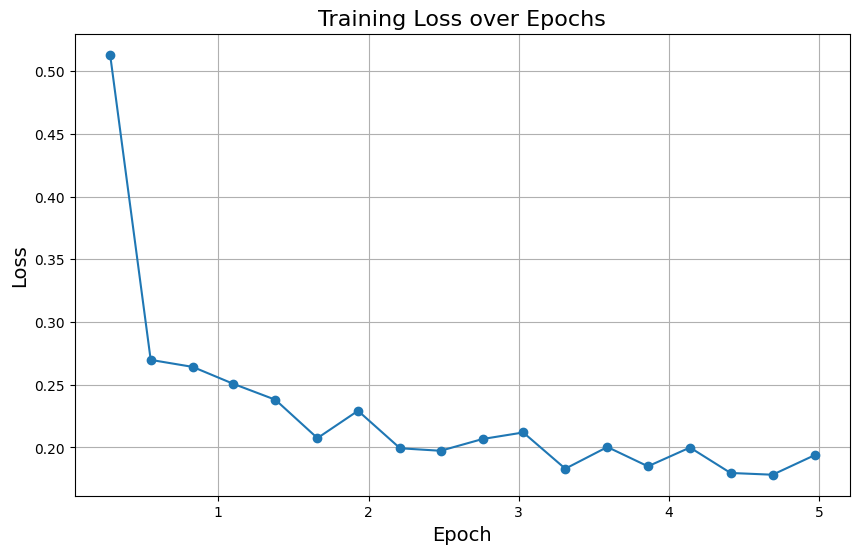

In [1]:
import matplotlib.pyplot as plt

# 从日志数据中提取所需信息
log_history = [
    {"epoch": 0.28, "learning_rate": 0.01954212454212454, "loss": 0.5132, "step": 50},
    {"epoch": 0.55, "learning_rate": 0.019084249084249084, "loss": 0.2698, "step": 100},
    {"epoch": 0.83, "learning_rate": 0.018626373626373628, "loss": 0.2642, "step": 150},
    {"epoch": 1.1, "learning_rate": 0.01816849816849817, "loss": 0.2507, "step": 200},
    {"epoch": 1.38, "learning_rate": 0.01771062271062271, "loss": 0.238, "step": 250},
    {"epoch": 1.66, "learning_rate": 0.017252747252747253, "loss": 0.2074, "step": 300},
    {"epoch": 1.93, "learning_rate": 0.016794871794871796, "loss": 0.2292, "step": 350},
    {"epoch": 2.21, "learning_rate": 0.016336996336996337, "loss": 0.1993, "step": 400},
    {"epoch": 2.48, "learning_rate": 0.015879120879120877, "loss": 0.1973, "step": 450},
    {"epoch": 2.76, "learning_rate": 0.015421245421245422, "loss": 0.2067, "step": 500},
    {"epoch": 3.03, "learning_rate": 0.014963369963369964, "loss": 0.2119, "step": 550},
    {"epoch": 3.31, "learning_rate": 0.014505494505494505, "loss": 0.183, "step": 600},
    {"epoch": 3.59, "learning_rate": 0.014047619047619047, "loss": 0.2003, "step": 650},
    {"epoch": 3.86, "learning_rate": 0.01358974358974359, "loss": 0.1849, "step": 700},
    {"epoch": 4.14, "learning_rate": 0.013131868131868132, "loss": 0.1999, "step": 750},
    {"epoch": 4.41, "learning_rate": 0.012673992673992674, "loss": 0.1796, "step": 800},
    {"epoch": 4.69, "learning_rate": 0.012216117216117218, "loss": 0.1782, "step": 850},
    {"epoch": 4.97, "learning_rate": 0.011758241758241758, "loss": 0.1938, "step": 900},
]

epochs = [entry['epoch'] for entry in log_history]
losses = [entry['loss'] for entry in log_history]

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.show()
